#### Projet P8: Déployer un modèle dans le cloud
Notebook: Prototypage en local pour un déploiement via des services cloud.<br />
Objectif du projet: Utiliser les services Amazon pour effectuer un préprocessing d'images pour un futur moteur de classification.<br />
Décembre 2021 Openclassroom - Formation Data Scientist<br />
Étudiant: Julien COUPIER<br />
Mentor: Florent Gbelidji<br />
Liste des contenus fournis pour ce projet: détails sur la dernière diapositive powerpoint de présentation du projet.

In [5]:
import os
import io
import bz2
import time
import shutil
import joblib
import pyspark
import botocore
import findspark
import boto3.session
import _pickle as cPickle

import numpy as np
import pandas as pd
import pyarrow as pa
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from glob import glob
from typing import Iterator, Tuple 
# from skimage import io
# from skimage.transform import resize

# connexion au cluster
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
# connexion à l'interface
from pyspark.sql import SparkSession

# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.input_file_name.html
from pyspark.sql.functions import col, split, reverse, input_file_name, pandas_udf, PandasUDFType
from pyspark.ml.feature import StringIndexer

# https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3
from tensorflow.keras.preprocessing.image import img_to_array
# transfer learning using pyspark
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

# Imports pour évaluation d'une baseline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import SGDClassifier

path = os.getcwd()

# !conda install -c anaconda bzip2
# !conda install -c conda-forge tensorflow
# !conda install -c conda-forge keras
# !conda install -c anaconda scikit-image
# !conda install -c anaconda scikit-learn
# !conda install -c conda-forge awscli
# !conda install -c anaconda boto3

#### Inspection du jeu de données
- Données: https://www.kaggle.com/moltean/fruits

In [5]:
path_storage = "G:/p8_jc_images/images"  # windows
# path_storage = path + '/data/images'  # linux
files_train = glob(path_storage + '/train/*')
files_test = glob(path_storage + '/test/*')

In [10]:
def display_img_nbr_per_folder(img_path, files_list, dir_nature_name, data_type):
    """
    Fonction qui permet de dénombrer les images par répertoire de type de fruits.
    Permet de savoir de combien l'on dispose d'images par catégorie pour l'entrainement d'un modèle.
    
    Args:
        img_path (string): Nom du chemin absolu du repertoire contenant toutes les images (train + test).
        files_list (list): Liste des adresses de toutes les images présentes dans un répertoire.
        dir_nature_name (string): Nom de la nature des données (titre graphique).
        data_type (string): Nom du répertoire que l'on veut inspecter.
        
    Returns:
        plt.show (graphique): Affiche un graphique avec le nombre d'images par catégories (dossiers).
        
    """

    cat_name = [fn.split("\\")[-1] for fn in files_list]  # windows
    # cat_name = [fn.split("/")[-1] for fn in files_train]  # linux
    # print(cat_name)
    print("Nombre de catégories de fruits:", len(cat_name), "\n")

    cat_img_nbr = []
    for cat in cat_name:
        img_nbr = len([img for img in os.listdir(img_path + '/' + data_type + '/' + cat)])
        cat_img_nbr.append(img_nbr)
        # print("{}: {}".format(cat, img_nbr))

    plt.style.use('ggplot')
    plt.figure(figsize=(12, 30))
    
    plt.barh(cat_name, cat_img_nbr, height=0.8, color='blue')
    
    plt.xlabel("Nombre d'images")
    plt.ylabel("Catégorie de fruits")
    plt.yticks(fontsize=12)
    img_cat_mean = np.mean(cat_img_nbr)
    plt.axvline(x=img_cat_mean, linewidth=3, color='r')
    plt.annotate("Moyenne", xy=(img_cat_mean+5, 132), size=12, color = 'r')
    plt.title(
        dir_nature_name +
        ": nombre d'images par catégorie de fruits \n avec une moyenne d'images de " +
        str(round(img_cat_mean, 2)) +
        " par catégorie."
    )
    
    return plt.show()

Nombre de catégories de fruits: 131 



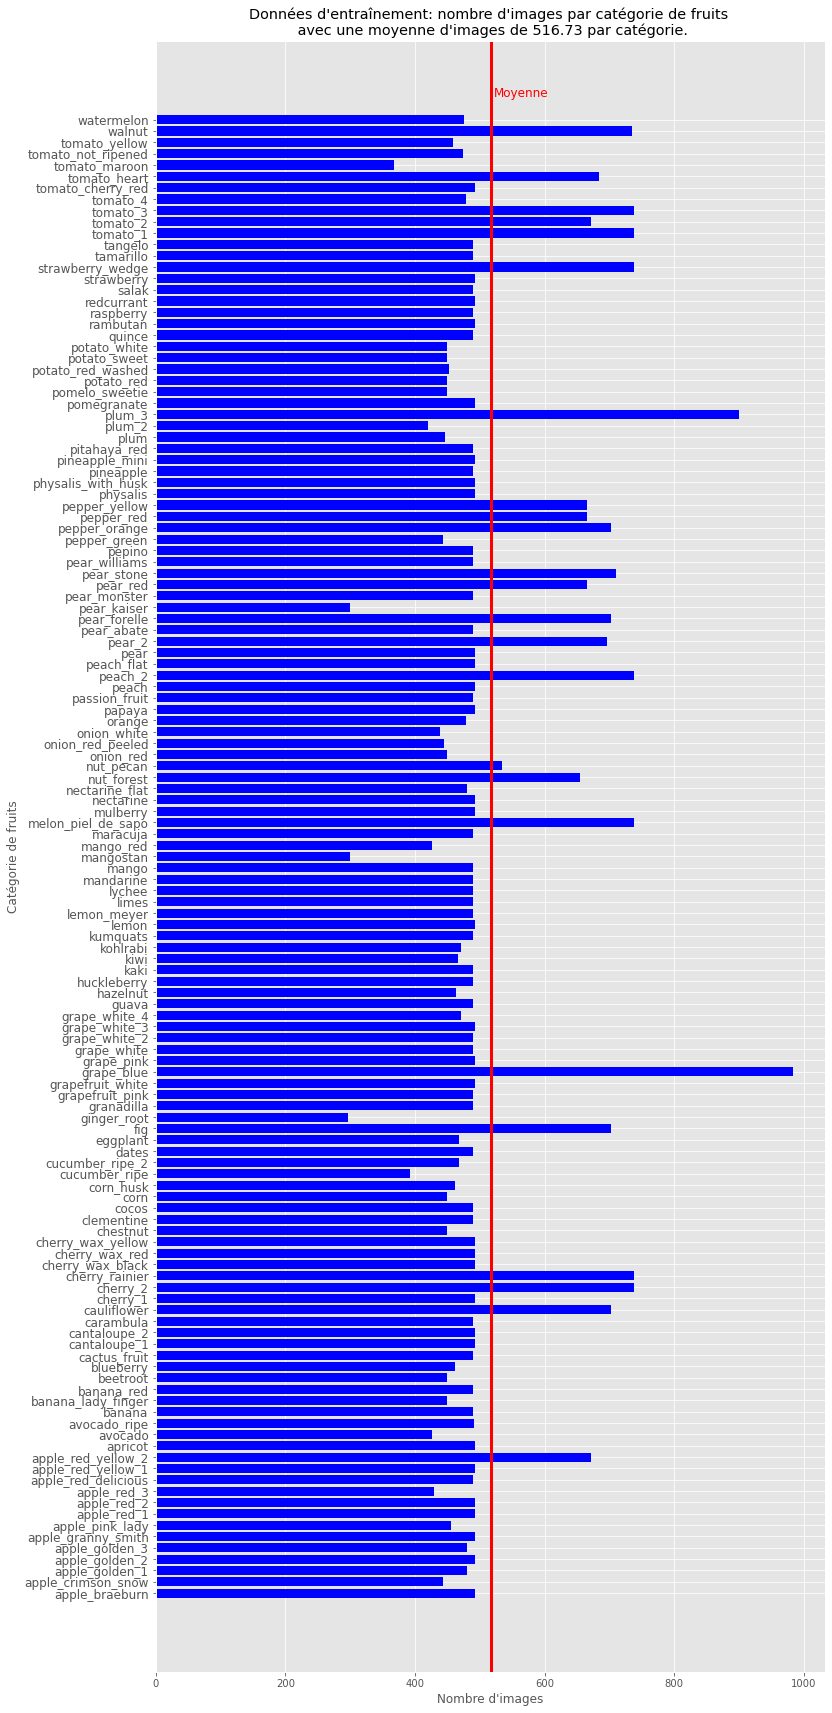

In [11]:
display_img_nbr_per_folder(path_storage, files_train, "Données d'entraînement", "train")

Nombre de catégories de fruits: 131 



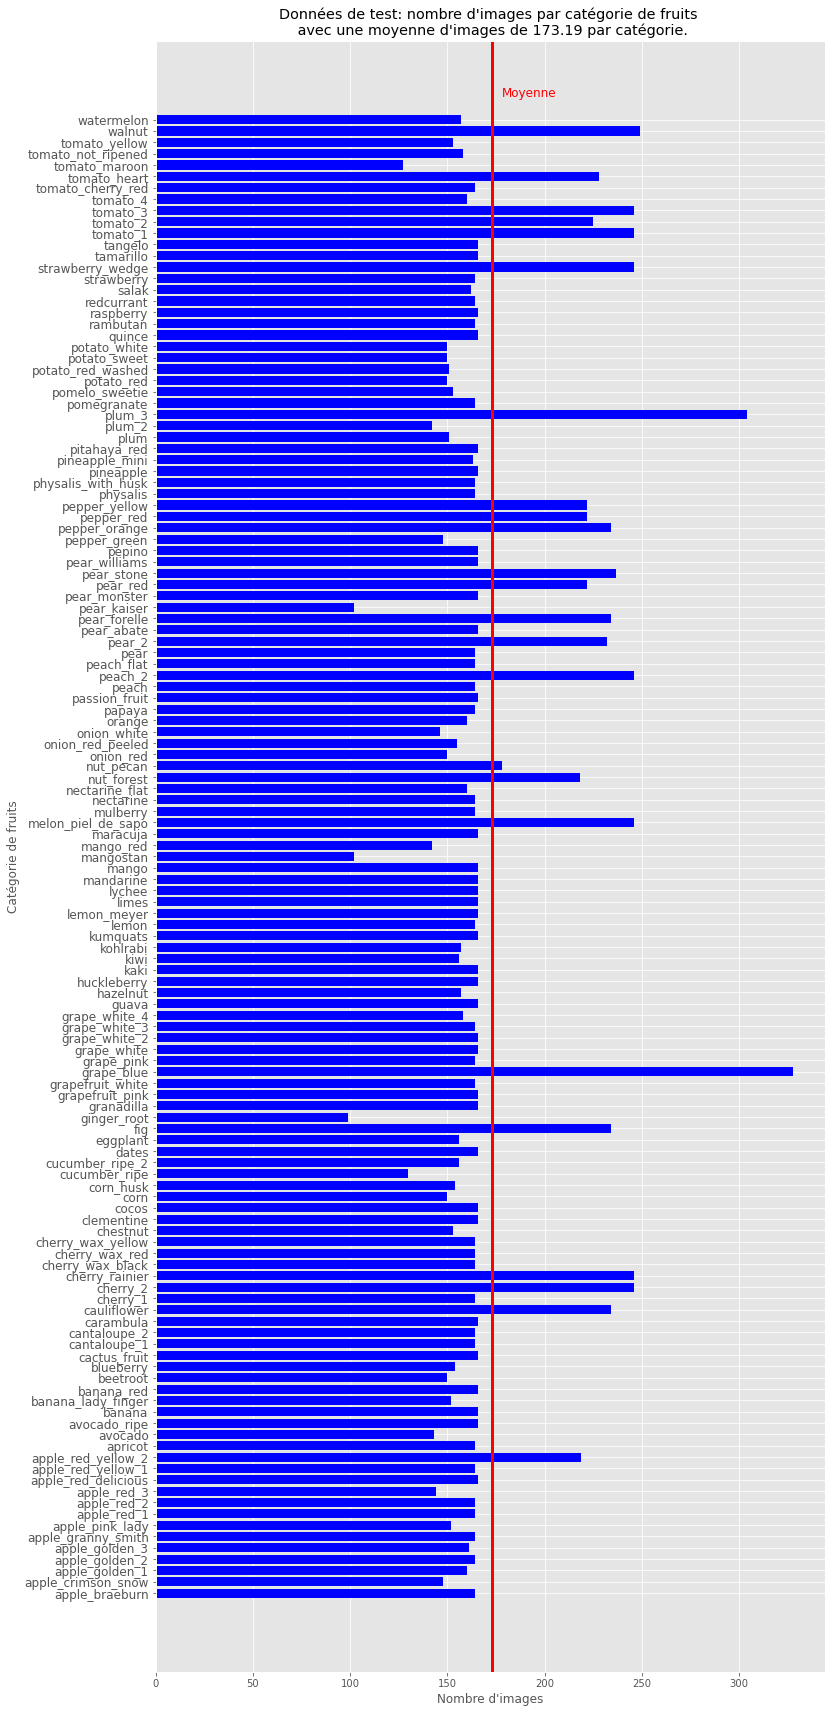

In [12]:
display_img_nbr_per_folder(path_storage, files_test, "Données de test", "test")

#### Visualisation d'un échantillon du type d'images du dataset (training et testing set)

##### DataFrame de labels: df_train_labels et df_test_labels

In [15]:
def gen_df_from_data(img_dir):
    """
    Fonction qui génère un dataframe avec le nom et le label des images contenues dans leur dossier rentré en paramètre.
    
    Args:
        img_dir (string): Chemin du dossier à inspecter pour créer le dataframe.
        
    Returns:
        df_labels (DataFrame): Dataframe de deux colonnes ("sub_url" et "img_name").
    """

    dict_labels = {}
    for folder in img_dir:
        folder_train_name = folder.split("\\")[-1]  # windows
        # folder_train_name = folder.split("/")[-1]  # linux
        # print(folder_train_name)
        images_name = [img_name for img_name in os.listdir(folder)]
        # print(images_name)
        images_url = [('/' + folder_train_name + '/' + img_name) for img_name in images_name]
        # print(images_url)
        for img_url in images_url:
            dict_labels[img_url] = folder_train_name

    df_labels = pd.DataFrame(dict_labels.items(), columns=['sub_url', 'img_name'])
    print("Taille du DataFrame: ", df_labels.shape)
    display(df_labels.head())
    
    return df_labels

In [16]:
train_dir = glob(path_storage + '/train/*')
df_train_labels = gen_df_from_data(train_dir)

Taille du DataFrame:  (67692, 2)


,sub_url,img_name
0,/apple_braeburn/0_100.jpg,apple_braeburn
1,/apple_braeburn/100_100.jpg,apple_braeburn
2,/apple_braeburn/101_100.jpg,apple_braeburn
3,/apple_braeburn/102_100.jpg,apple_braeburn
4,/apple_braeburn/103_100.jpg,apple_braeburn


In [17]:
test_dir = glob(path_storage + '/test/*')
df_test_labels = gen_df_from_data(test_dir)

Taille du DataFrame:  (22688, 2)


,sub_url,img_name
0,/apple_braeburn/321_100.jpg,apple_braeburn
1,/apple_braeburn/322_100.jpg,apple_braeburn
2,/apple_braeburn/323_100.jpg,apple_braeburn
3,/apple_braeburn/324_100.jpg,apple_braeburn
4,/apple_braeburn/325_100.jpg,apple_braeburn


##### Visualisation du type d'images (échantillon)

In [18]:
# pour la reproductivité du graphique
np.random.seed(42)

def load_sample(df, sample_size):
    """
    Fonction qui génére un échantillon provenant du dataframe df_labels.
    
    Args:
        df (DataFrame): Dataframe de labels. Résultat de la fonction gen_df_from_data().
        sample_size (int): Nombre d'images de l'échantillon.
    
    Returns:
        df_sample (DataFrame): Un échantillon aléatoire du dataframe original.
    """
    
    df_sample = df.loc[np.random.permutation(np.arange(0, len(df)))[:sample_size], :]
    
    return df_sample

def display_sample(img_path_root, sample_df, grid_width, grid_height, im_scale_x, im_scale_y):
    """
    Fonction qui permet d'afficher l'échantillon d'images sélectionnées suivant une taille et un alignement de grille.
    
    Args:
        img_path_root (string): Chemin racine du dossier contenant les images.
        sample_df (DataFrame): Dataframe d'entrée servant à générer l'échantillon d'images.
        grid_with (int): Nombre d'éléments (images) en largeur pour grille pour plt.subplots. (Ajustement à effectuer suivant le nombre total d'images).
        grid_height (int): Nombre d'éléments (images) en hauteur pour grille pour plt.subplots. (Ajustement à effectuer suivant le nombre total d'images).
        im_scale_x (int):  Taille des images en largeur pour le positionnement sur la grille. (Ajustement à effectuer suivant le nombre total d'images).
        im_scale_y (int): Taille des images en hauteur pour le positionnement sur la grille. (Ajustement à effectuer suivant le nombre total d'images).
        
    Returns:
        plt.show() (Graphique): Graphique d'échantillons issu du jeu de données train ou test suivant le paramètre "sample_df".
    """
    
    fig, ax = plt.subplots(grid_width, grid_height)
    fig.set_size_inches(10, 10)
    
    img_idx = 0
    for x in range(0, grid_width):
        for y in range(0, grid_height):
            ax[x][y].axis('off')  # enlève l'affiche de grille par défaut
            ax[x][y].set_title(sample_df.iloc[img_idx]['img_name'][:12])  # on récupère le nom de la catégorie de l'image (limitée à 12 chars)
            img = io.imread(img_path_root + sample_df.iloc[img_idx]['sub_url'])
            img_resized  = resize(img, (im_scale_x, im_scale_y), anti_aliasing=True)
            ax[x][y].imshow(img_resized)  # affichage de l'image
            img_idx += 1
    
    # alignement cosmétique
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0.25)
    
    return plt.show()

In [21]:
from skimage import io
from skimage.transform import resize

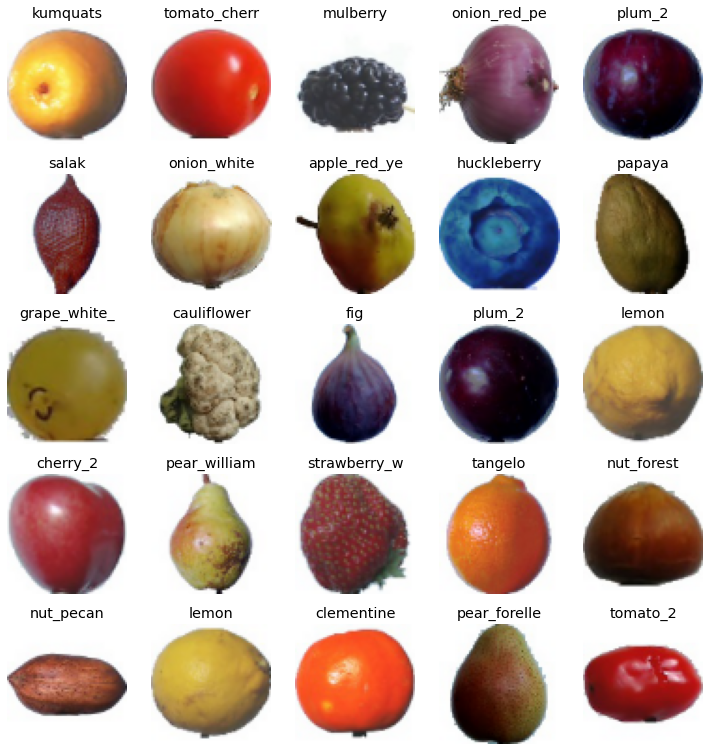

In [22]:
# tests des fonctions avec le jeu d'entraînement
df_train_sample = load_sample(df_train_labels, sample_size=25)
display_sample(path_storage + '/train', df_train_sample, grid_width=5, grid_height=5, im_scale_x=64, im_scale_y=64)

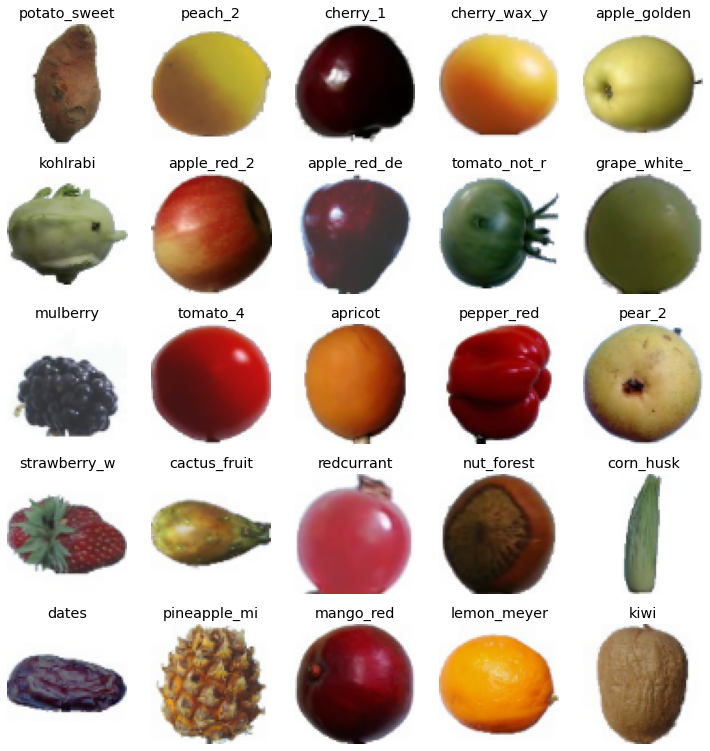

In [23]:
df_test_sample = load_sample(df_test_labels, sample_size=25)
display_sample(path_storage + '/test', df_test_sample, grid_width=5, grid_height=5, im_scale_x=64, im_scale_y=64)

#### Préparation des données pour la création d'une baseline de classification

Notes:<br />
Question: PCA: utile sur les images d'origine ?<br />
Deux avantages possibles:<br />
- réduction de dimensions permettant une amélioration des résultats (à vérifier avec le classifier utilisé ensuite)
- permet de réduire la taille globale des données et donc également la puissance de calcul allouée (très utile pour un ordinateur peu puissant)

Localisation de l'images: /watermelon/r_99_100.jpg
Dimensions de l'image:    (100, 100, 3)


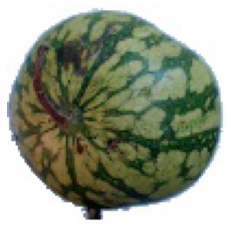

In [24]:
# Affichage de la dernière image du jeu de test
img_path = path_storage + '/test/'
img = io.imread(img_path + df_test_labels.iloc[-1]['sub_url'])
print("Localisation de l'images:", df_test_labels.iloc[-1]['sub_url'])
print("Dimensions de l'image:   ", img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()

In [25]:
img_arr = img.flatten().reshape(1, 100*100*3)
print(img_arr.shape)

(1, 30000)


##### Fonctions de "Pickle" with compression

In [7]:
# fonctions pour la compression et décompression,
# But: gagner en espace disque par rapport aux fichiers pikle par défaut
# https://docs.python.org/3/library/bz2.html
def pickle_w_compression(filename, data):
    with bz2.BZ2File(path + '/' + filename + '.pbz2', mode='w',  compresslevel=9) as file:
        cPickle.dump(data, file)
    return

def decompress_pickle(filename):
    data = bz2.BZ2File(path + '/' + filename + '.pbz2', mode='rb')
    data = cPickle.load(data)
    return data

In [78]:
%%script echo skipping
# création d'un dataframe global (train + test) pour la PCA

img_train_path = path_storage + '/train/'
img_test_path = path_storage + '/test/'

def gen_df_for_pca(dir_path, df_labels, name_for_df_part):
    """
    Fonction qui génère un dataframe utilisable ensuite pour la PCA.
    Création du dataframe global pour découpage de la tâche à réaliser par partie.
    
    Args:
        dir_path (string): Chemin du dossier d'images (d'entraînement ou de test).
        df_labels (DataFrame): DataFrame contenant les labels (d'entraînement ou de test).
        name_for_df_pars (string): Nom des parties de DataFrames qui seront générées.
        
    Returns:
        df_img_flat (DataFrame): DataFrame avec les vecteurs d'images (flatten arrays).
    """

    # list_img_flat = []
    df_img_flat_part = pd.DataFrame()
    # len_df_labels = len(df_labels)
    
    # division en 10 parties pour alleger la mémoire à la création du dataframe
    df_part_01, df_part_02, df_part_03, df_part_04, df_part_05,\
    df_part_06, df_part_07, df_part_08, df_part_09, df_part_10 = np.array_split(df_labels, 10)
    
    df_parts_list = [df_part_01, df_part_02, df_part_03, df_part_04, df_part_05,
                    df_part_06, df_part_07, df_part_08, df_part_09, df_part_10]
    
    for part_nbr, df_part in enumerate(df_parts_list):
        
        print("//----- Part_" + str(part_nbr+1) + " -----//")

        len_df_part = len(df_part)
        df_img_flat_part = pd.DataFrame(columns=[col for col in range(0, 64*64*3)])
        # print(df_img_flat_part.shape)
        
        for img_idx, img_row in df_part.iterrows():
            
            img = io.imread(dir_path + img_row['sub_url'])
            img_rez = resize(img, (64, 64), anti_aliasing=True)  # resize d'image pour réduire les dimensions
            img_arr = img_rez.flatten()
            
            # ajout des images "flatten" sous forme de Series as a row.
            # df_img_flat_part = pd.concat([df_img_flat_part, pd.Series(img_arr)], axis=1, ignore_index=True).T # -> timeit très mauvais.
            df_img_flat_part.loc[img_idx] =  img_arr
            df_img_flat_part = df_img_flat_part.astype('float32')  # spécification du type ici pour réduire la taille en mémoire (pas de float64)
            progress = round((img_idx/len_df_part)*100, 2)
            print("{} % part done ".format(progress), end="\r")
            
        file_name = name_for_df_part + '_part_' + str(part_nbr + 1)  # pour éviter de commencer à zéro
        # df_img_flat_part.to_pickle(path + '/' + file_name)
        pickle_w_compression(file_name, df_img_flat_part)
            
        print(df_img_flat_part.shape)
        # print(df_img_flat_part.head(), "\n")
        # pour la mémoire
        del df_img_flat_part
    
    # une fois toutes les parties créées, on les ajoute pour créer un dataframe global
    df_img_flat = pd.DataFrame()
    for part_nbr in range(1, 11):
        
        file_name = name_for_df_part + '_part_' + str(part_nbr)

        df_img_flat_part = decompress_pickle(file_name)
        
        df_img_flat = pd.concat([df_img_flat, df_img_flat_part], axis=0, ignore_index=True)
        print("//----- part_" + str(part_nbr) + " recovered -----//")
        
        # pour la mémoire
        del df_img_flat_part
    
    return df_img_flat

In [80]:
%%script echo skipping
%%time
df_train_img_flat = gen_df_for_pca(img_train_path, df_train_labels, "df_train_flat")

Couldn't find program: 'echo'


In [81]:
%%script echo skipping
pickle_w_compression("df_train_img_flat", df_train_img_flat)
del df_train_img_flat

Couldn't find program: 'echo'


In [82]:
%%script echo skipping
%%time
df_test_img_flat = gen_df_for_pca(img_test_path, df_test_labels, "df_test_flat")

Couldn't find program: 'echo'


In [83]:
%%script echo skipping
pickle_w_compression("df_test_img_flat", df_test_img_flat)
del df_test_img_flat

Couldn't find program: 'echo'


In [84]:
%%script echo skipping
# Pour la mémoire sur un petit PC, c'est mieux de d'étager les opérations
# On récompose le dataframe global pour la PCA

df_train_img_flat = decompress_pickle("df_train_img_flat")
df_test_img_flat = decompress_pickle("df_test_img_flat")

df_img_flat = pd.concat([df_train_img_flat, df_test_img_flat], axis=0, ignore_index=True)
pickle_w_compression("df_img_flat", df_img_flat)

del df_train_img_flat
del df_test_img_flat

Couldn't find program: 'echo'


##### Chargement de "df_img_flat"
DataFrame global pour la PCA

In [91]:
%%script echo skipping
%%time
# Chargement du dataframe pour la PCA
df_img_flat = decompress_pickle("df_img_flat")

Wall time: 2min 52s


In [92]:
%%script echo skipping
print("df_img_flat.shape", df_img_flat.shape)

df_img_flat.shape (90380, 12288)


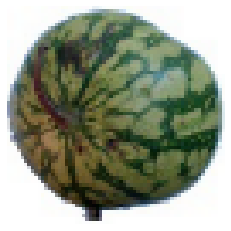

In [93]:
%%script echo skipping
# test avec affichage d'umage en particulier
img_test = df_img_flat.iloc[-1].values.reshape(64, 64, 3)
plt.imshow(img_test)
plt.axis('off')
plt.show()

In [94]:
%%script echo skipping
print(df_img_flat.shape)
display(df_img_flat.head())

(90380, 12288)


##### Centrage des données, (et pas de scaling) avant PCA 
Besoin de centrer les données pour la PCA. L'ensemble des pixels partagent la même échelle, pas besoin de standardiser.

In [5]:
%%script echo skipping
%%time
# Chargement du dataframe pour la PCA
df_img_flat = decompress_pickle("df_img_flat")
print("df_img_flat.shape", df_img_flat.shape)

df_img_flat.shape (90380, 12288)
Wall time: 2min 42s


In [7]:
%%script echo skipping
scaler = StandardScaler(with_mean=True, with_std=False)
arr_img_flat_std = scaler.fit_transform(df_img_flat)
print(arr_img_flat_std.shape)

(90380, 12288)


In [9]:
%%script echo skipping
df_img_flat_std = pd.DataFrame(arr_img_flat_std)
df_img_flat_std.agg(['min', 'max', 'mean']).head()

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
min,-3.615991e-01,-3.059393e-01,-2.322735e-01,-3.551733e-01,-3.357520e-01,-2.906070e-01,-8.311627e-01,-8.070679e-01,-7.842824e-01,-9.696246e-01,...,-5.135126e-02,-1.457307e-02,-8.937106e-03,-1.914487e-02,-1.132334e-02,-1.097867e-02,-2.105459e-02,-9.737897e-03,-9.255439e-03,-1.722886e-02
max,1.322145e-03,7.664409e-04,1.565387e-03,1.061346e-03,7.254478e-04,1.212878e-03,1.029401e-03,6.986829e-04,1.103586e-03,1.101503e-03,...,1.590316e-05,1.027953e-05,8.955180e-06,1.105034e-05,9.434720e-07,9.819895e-07,8.672865e-07,9.060137e-07,8.646162e-07,7.568629e-07
mean,-5.781617e-08,-7.232061e-10,-1.036834e-07,6.289542e-08,-2.487357e-08,1.277864e-07,-1.135798e-08,-6.420663e-08,-7.998612e-08,-4.291052e-09,...,-6.682582e-10,7.899124e-10,3.859466e-10,1.444455e-09,-2.454490e-10,5.220261e-10,3.621615e-10,-4.310109e-10,-2.733184e-10,-3.203325e-10


##### PCA: pour économiser des ressources et réduire le nombre de dimensions
Note: Cela revient à faire de la "compression" d'images en conservant le maximum d'informations utilisable pour un modèle

In [10]:
%%script echo skipping
%%time
pca = PCA(n_components=1000)
pca.fit(df_img_flat_std)

Wall time: 1min 49s


PCA(n_components=1000)

Taux de variance total expliqué: 99 %


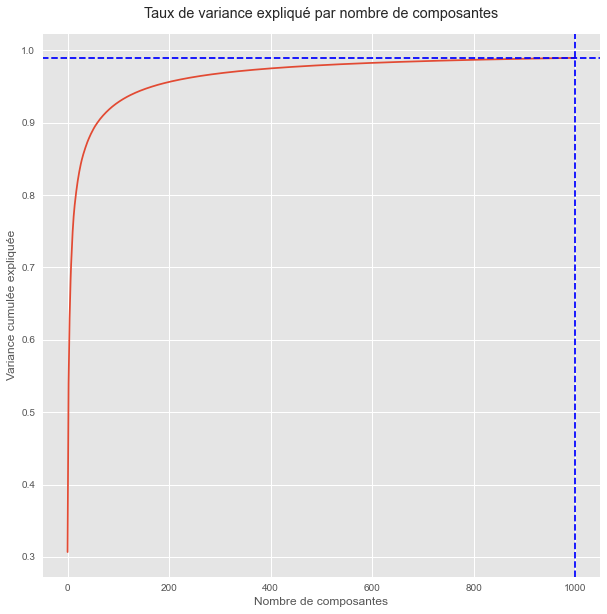

In [22]:
%%script echo skipping
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))

plt.plot(pca.explained_variance_ratio_.cumsum())
print("Taux de variance total expliqué: {} %".format(round(100 * sum(pca.explained_variance_ratio_))))

plt.title("Taux de variance expliqué par nombre de composantes", pad=15)
plt.axhline(y=0.99, color='b', linestyle='--')
plt.axvline(x=1000, color='b', linestyle='--')
plt.xlabel("Nombre de composantes")
plt.ylabel("Variance cumulée expliquée")

plt.show()


In [98]:
# simple vérficiation
%%script echo skipping
print(len(pca.components_))

1000


In [23]:
%%script echo skipping
%%time
arr_img_flat_std_pca = pca.transform(df_img_flat_std)
print(arr_img_flat_std_pca.shape)

(90380, 1000)
Wall time: 9.55 s


In [29]:
%%script echo skipping
%%time
pickle_w_compression("arr_img_flat_std_pca", arr_img_flat_std_pca)
del arr_img_flat_std_pca

Couldn't find program: 'echo'


##### Chargement: df_img_flat_std_pca

In [27]:
%%time
# chargement du résult de la PCA (rappel: c'est bien un array)
arr_img_flat_std_pca = decompress_pickle("arr_img_flat_std_pca")
print("arr_img_flat_std_pca.shape", arr_img_flat_std_pca.shape)
print(type(arr_img_flat_std_pca))
print(arr_img_flat_std_pca.dtype)

arr_img_flat_std_pca.shape (90380, 1000)
<class 'numpy.ndarray'>
float32
Wall time: 25 s


In [28]:
# On créé un DataFrame
df_img_flat_std_pca = pd.DataFrame(arr_img_flat_std_pca)
display(df_img_flat_std_pca.shape)
display(df_img_flat_std_pca.info())

(90380, 1000)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90380 entries, 0 to 90379
Columns: 1000 entries, 0 to 999
dtypes: float32(1000)
memory usage: 344.8 MB


None

#### Création d'une Baseline
Problème: identique à la création du DataFrame, on a un problème de RAM en utilisant un petit ordinateur
- Tentative avec une RFC (pas de KNC car cela fait planter le PC) avec une grille très allégée en hyperparamètres
- Tentative avec SGBClassifier avec l'utilisation de fits partiels !<br />
Ressources: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

##### Préparation des données

In [29]:
display(df_train_labels.info())
display(df_test_labels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67692 entries, 0 to 67691
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sub_url   67692 non-null  object
 1   img_name  67692 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22688 entries, 0 to 22687
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sub_url   22688 non-null  object
 1   img_name  22688 non-null  object
dtypes: object(2)
memory usage: 354.6+ KB


None

In [30]:
df_img_train_std_pca = df_img_flat_std_pca.iloc[0:67692]
df_img_test_std_pca = df_img_flat_std_pca.iloc[67692:]
print("df_img_train_std_pca.shape", df_img_train_std_pca.shape)
print("df_img_test_std_pca.shape", df_img_test_std_pca.shape)

df_img_train_std_pca.shape (67692, 1000)
df_img_test_std_pca.shape (22688, 1000)


##### Création de X_train et X_test

In [31]:
# On repasse en array
X_train = df_img_train_std_pca.to_numpy()
X_test = df_img_test_std_pca.to_numpy()

##### Utilisation du LabelEncoder

In [32]:
# labelencoder
display(df_train_labels.head())
display(df_test_labels.head())

le = LabelEncoder()
le.fit(df_train_labels['img_name'])
y_train = le.transform(df_train_labels['img_name'])
y_test = le.transform(df_test_labels['img_name'])

print("y_train.shape", y_train.shape, type(y_train))
print("y_test.shape", y_test.shape, type(y_test))

,sub_url,img_name
0,/apple_braeburn/0_100.jpg,apple_braeburn
1,/apple_braeburn/100_100.jpg,apple_braeburn
2,/apple_braeburn/101_100.jpg,apple_braeburn
3,/apple_braeburn/102_100.jpg,apple_braeburn
4,/apple_braeburn/103_100.jpg,apple_braeburn


,sub_url,img_name
0,/apple_braeburn/321_100.jpg,apple_braeburn
1,/apple_braeburn/322_100.jpg,apple_braeburn
2,/apple_braeburn/323_100.jpg,apple_braeburn
3,/apple_braeburn/324_100.jpg,apple_braeburn
4,/apple_braeburn/325_100.jpg,apple_braeburn


y_train.shape (67692,) <class 'numpy.ndarray'>
y_test.shape (22688,) <class 'numpy.ndarray'>


##### SGBClassifier et fit partiel
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [33]:
# rappel et vérification
print(X_train.shape)

(67692, 1000)


In [34]:
# mélange des données (=shuffle) pour mélanger les types par variété de fruits
np.random.seed(42)
idx = np.arange(X_train.shape[0])
np.random.shuffle(idx)
X_train_shuffled = X_train[idx]
y_train_shuffled = y_train[idx]
print(idx[:10])

[21874 67509 48375 60571  3292 58710 25799  7220 29450 65633]


In [35]:
def gen_batch(iter_X, iter_y, step=1):
    """
    Fonction (générateur) qui permet de créer des batchs pour le fit_partial.
    """
    iter_len = len(iter_X)
    for idx in range(0, iter_len, step):
        yield iter_X[idx:min(idx + step, iter_len)], iter_y[idx:min(idx + step, iter_len)]

In [40]:
%%script echo skipping
%%time
# Initialisation avec hyperparamètres aux valeurs "classiques/courantes"
clf = SGDClassifier(
    alpha = 0.0001,
    loss = 'log',
    penalty = 'l2',
    n_jobs = 2,  # -1
    shuffle = True,
    max_iter = 100,
    verbose = 0,  # 1
    tol = 0.001    
)

runs = 15
scores = {}
for nbr, run in enumerate(range(runs)):
    batch_generator = gen_batch(X_train_shuffled, y_train_shuffled, 10)
    for idx, (chunk_X, chunk_y) in enumerate(batch_generator):
        clf.partial_fit(chunk_X, chunk_y, classes=list(set(y_train)))
        y_pred = clf.predict(X_test)
        scores[run] = accuracy_score(y_test, y_pred)
    print("Score pour le run {}: {:.2f}".format(nbr, scores[nbr]))

Couldn't find program: 'echo'


In [37]:
%%script echo skipping
pickle_w_compression("sgd_classfier_trained", clf)
pickle_w_compression("sgd_classfier_scores", scores)

Couldn't find program: 'echo'


In [9]:
scores = decompress_pickle("sgd_classfier_scores")

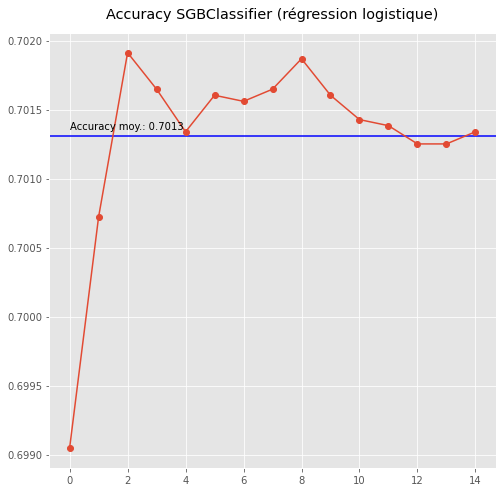

In [11]:
# Affichage des scores par run
# La moyenne va donner une baseline
x = np.arange(len(scores))
y = [value for value in scores.values()]

plt.style.use('ggplot')
plt.figure(figsize=(8, 8))
plt.title("Accuracy SGBClassifier (régression logistique)", pad=15)
plt.axhline(y=np.mean(y), color='b', linestyle='-')
plt.annotate("Accuracy moy.: {:.4f}".format(np.mean(y)), (0, np.mean(y)+0.00005))
plt.plot(x, y, '-o')
plt.show()

#####  Fonction Joblib simple pour la sauvegarde des modèles et résultats (pas besoin de compression ici)

In [41]:
def save_load_gs_model(action, model_name, gs_model=None):
    """
    Fonction qui permet de sauvegarder ou charger une copie d'un modèle issu d'une GridSearchCV (ou autre).
    
    Args:
        action (string): "load" ou "save" pour charger ou sauvegarder les modèles entraînés avec les hyperparamètres.
        gs_model (object): instance du modèle.
        model_name (string) : nom de du modèle. 
        
    Returns:
        Le modèle entraîné avec les meilleurs hyperparamètres trouvés.
    """
    # model_name = f'{gs_model=}'.split('=')[0] # pas de référence, out of scope -> dommage ne fonctionne pas
    model_name = str(model_name)
    
    if action == 'save':
        try:
            joblib.dump(gs_model, path + '/' + model_name + '.pkl')
            return
            
        except Exception as e:
            print("L'action demandée n'a pas abouti. Vérifiez le chemin et/ou le fichier utilisé.")
            return
        
    if action == 'load':
        try:
            joblib_gs_model = joblib.load(path + '/' + model_name + '.pkl')
            return joblib_gs_model
            
        except Exception as e:
            print("L'action demandée n'a pas abouti. Vérifiez le chemin et/ou le fichier utilisé.")
            return

##### Baseline avec un RandomForestClassifier
Si la faible puissance du PC le permet, cela ferait une baseline plus intéressante.<br />
Cependant la taille de la grille de recherche d'hyperparamètres, risque d'être très limitée. (RandomGridSearch idem)

GridSearch avec RFC

In [155]:
%%script echo skipping
rfc_std_params = {
    'n_estimators' : [400],  # [150, 200, 250, 300], [250, 300, 350, 400]
    'max_depth': [15],  # np.arange(5, 20, 2), [2, 5, 10, 15, 20]
    'criterion' : ['gini'],  # ['gini', 'entropy'],
    'max_features' : ['auto'],  # ['auto', 'sqrt', 'log2'],
    'class_weight' : ['balanced_subsample']  # {0:1, 1:8}], ['balanced', 'balanced_subsample']

}

rfc_std_k_folds = 5  # 3, 5
rfc_std_scoring = 'accuracy'

gs_rfc_std_pca = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid = rfc_std_params,
    cv = rfc_std_k_folds,
    scoring = rfc_std_scoring,
    n_jobs = 3, # -1
    verbose = 1
)

In [158]:
%%script echo skipping
%%time
gs_rfc_std_pca.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 1h 27min 57s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=3,
             param_grid={'class_weight': ['balanced_subsample'],
                         'criterion': ['gini'], 'max_depth': [15],
                         'max_features': ['auto'], 'n_estimators': [400]},
             scoring='accuracy', verbose=1)

In [160]:
%%script echo skipping
save_load_gs_model('save', 'gs_rfc_std_pca', gs_rfc_std_pca)

In [161]:
joblib_gs_rfc_std_pca = save_load_gs_model('load', 'gs_rfc_std_pca')
print("gs_rfc_std_pca :", joblib_gs_rfc_std_pca.best_params_)

gs_rfc_std_pca : {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 400}


In [162]:
y_pred_rfc_std_pca = joblib_gs_rfc_std_pca.predict(X_test)
print("Accuracy sur le jeu de test : {}".format(joblib_gs_rfc_std_pca.score(X_test, y_test)))

Accuracy sur le jeu de test : 0.8289404090267983


In [163]:
# matrice de confusion
cm_rfc_std_pca = confusion_matrix(y_test, y_pred_rfc_std_pca)
print(cm_rfc_std_pca)

[[119   0   0 ...   0   0   0]
 [  0 116   0 ...   0   8   0]
 [  0   0 113 ...   0   0   0]
 ...
 [  0   0   0 ... 153   0   0]
 [  0   0   0 ...   0 249   0]
 [  0   0   0 ...   0   0 153]]


In [164]:
# rapport de classification
print(classification_report(y_test, y_pred_rfc_std_pca))

              precision    recall  f1-score   support

           0       0.70      0.73      0.71       164
           1       0.62      0.78      0.69       148
           2       0.85      0.71      0.77       160
           3       0.92      0.85      0.88       164
           4       0.58      0.99      0.74       161
           5       0.79      0.88      0.83       164
           6       0.71      0.66      0.69       152
           7       0.80      0.57      0.67       164
           8       0.76      0.66      0.71       164
           9       0.71      0.60      0.65       144
          10       0.89      0.99      0.94       166
          11       0.80      0.90      0.85       164
          12       0.91      0.91      0.91       219
          13       0.79      0.71      0.75       164
          14       0.85      0.78      0.81       143
          15       0.90      0.86      0.88       166
          16       0.75      0.68      0.72       166
          17       0.96    

##### Baseline avec KNN Classifier
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html<br />
Note: Pas assez de puissance côté PC même en ajustant avec le paramètre n_jobs<br />
Code laissé pour mémoire (à réessayer avec un ordinateur plus puissant i7 Core et 32 de RAM ?)

In [ ]:
%%script echo skipping
# même chose avec un KNN Classifier

knc_std_params = {
    'n_neighbors' : [5],  # [5]
    'weights': ['uniform', 'distance'],  # ['uniform', 'distance']
    'algorithm' : ['auto'],  # ['auto']
    'leaf_size' : ['30'],  # [30]

}

knc_std_k_folds = 5  # 3, 5
knc_std_scoring = 'accuracy'

gs_knc_std_pca = GridSearchCV(
    KNeighborsClassifier(),
    param_grid = knc_std_params,
    cv = knc_std_k_folds,
    scoring = knc_std_scoring,
    n_jobs = -1, # -1, 2, 3
    verbose = 1
)

In [ ]:
%%script echo skipping
%%time
gs_knc_std_pca.fit(X_train, y_train)

In [ ]:
%%script echo skipping
save_load_gs_model('save', 'gs_knc_std_pca', gs_knc_std_pca)

In [ ]:
%%script echo skipping
joblib_gs_knc_std_pca = save_load_gs_model('load', 'gs_knc_std_pca')
print("gs_knc_std_pca :", joblib_gs_knc_std_pca.best_params_)

In [ ]:
%%script echo skipping
y_pred_knc_std_pca = joblib_gs_knc_std_pca.predict(X_test)
print("Accuracy sur le jeu de test : {}".format(joblib_gs_knc_std_pca.score(X_test, y_test)))

In [ ]:
%%script echo skipping
# matrice de confusion
cm_knc_std_pca = confusion_matrix(y_test, y_pred_knc_std_pca)
print(cm_knc_std_pca)

In [ ]:
%%script echo skipping
# rapport de classification
print(classification_report(y_test, y_pred_knc_std_pca))

 #### Modèles populaires pour la classification d'images
 Référence documentation: https://keras.io/api/applications/
 - VGG-16 (Université d'Oxford -> 2014) -> Input shape Keras -> (224, 224, 3)
 - Inceptionv3 (GoogLeNet -> Google -> 2014 ?) -> Input shape Keras -> (299, 299, 3)
 - EfficientNet (Google) -> Input shape Keras -> (224, 224, 3)
 - ResNet50V2 (Computer Vision domain -> 2015) -> Input shape Keras -> (224, 224, 3)
 - MobileNetV2 -> Input shape Keras -> (224, 224, 3)

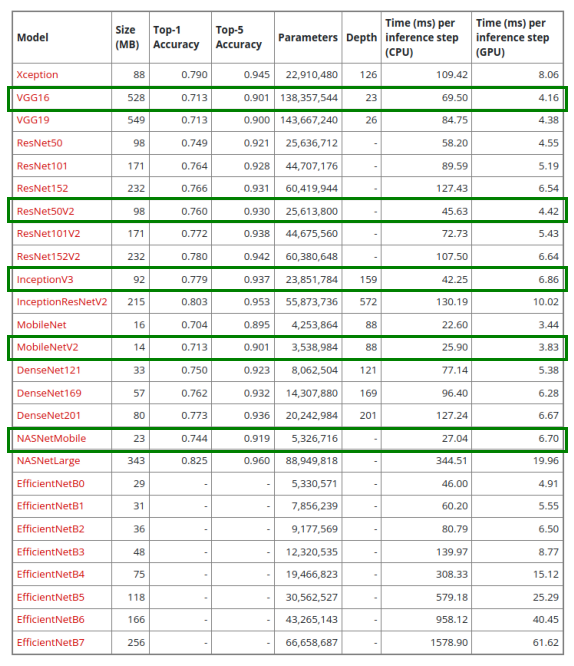

In [50]:
# affichage pour comparaison des modèles "raisonnables" à disposition pour cette problématique
img_ref_keras = io.imread(path + '/img/performance_model_keras_classification.png')
# print(img_ref_keras.shape)  # (851, 731, 3)

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img_ref_keras)
plt.axis('off')
rect_restnet50v2 = patches.Rectangle(
    (0, 250),  # origine
    729,  # largeur - linewidth
    30,  # longueur (hauteur)
    linewidth=3,
    edgecolor='g',
    facecolor='none'
)

rect_inceptionv3 = patches.Rectangle((0, 340), 729, 30, linewidth=3, edgecolor='g', facecolor='none')
rect_mobilenetv2 = patches.Rectangle((0, 430), 729, 30, linewidth=3, edgecolor='g', facecolor='none')
rect_nasnetmobile = patches.Rectangle((0, 550), 729, 30, linewidth=3, edgecolor='g', facecolor='none')
rect_vgg16 = patches.Rectangle((0, 105), 729, 30, linewidth=3, edgecolor='g', facecolor='none')

ax.add_patch(rect_restnet50v2)
ax.add_patch(rect_inceptionv3)
ax.add_patch(rect_mobilenetv2)
ax.add_patch(rect_nasnetmobile)
ax.add_patch(rect_vgg16)

plt.show()

- Comparaison de performance entre modèles sur ImageNet
- Référence: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html

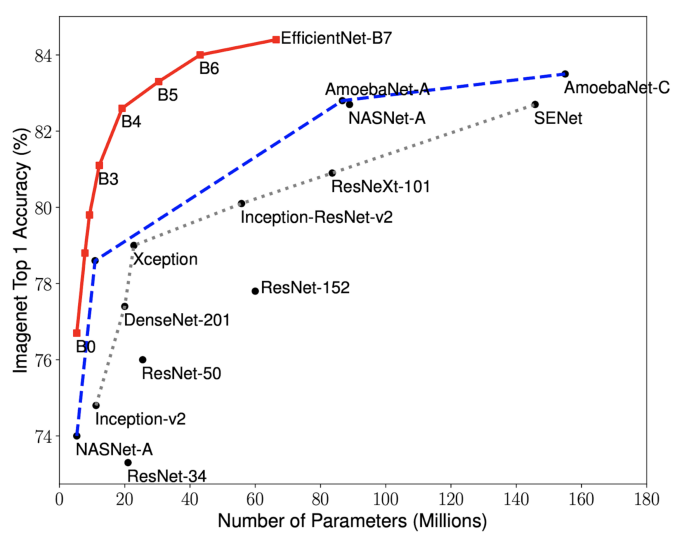

In [42]:
img_ref_google = io.imread(path + '/img/performance_model_google_classification.png')
plt.figure(figsize=(12, 12))
plt.imshow(img_ref_google)
plt.axis('off')
plt.show()

- Transfer Learning: mon choix -> InceptionV3 model from Keras
- Utilisation d'un modèle pré-entraîné (=features extrator) avec ImageNet
- Référence: https://keras.io/api/applications/inceptionv3/
- Bien que l'on pourrait opter pour du Fine Tuning, ici ce n'est pas demandé.
- En effet: le fait d'avoir plusieurs types de fruits par catégorie permettrait d'envisager le Fine Tuning en "freezant" les couches supérieures du modèle choisi.<br /> Et ensuite de le ré-entraîner seulement avec les couches supérieures pour gagner en apprentissage sur les variétés d'une même classe de fruit.

#### Test de la CLI v2 Amazon services (ici le stockage avec S3)
Boto3: Python SDK for AWS
https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html

Rappel: Suppose avoir configuré ses clefs avec "aws configure" (IAM) et renseigné les groups policy (ACL) pour l'utilisation sans risque (= pas d'accès publique par défaut)

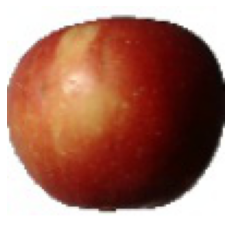

In [53]:
# Commentaires pour mémoire
# -> dans l'environnement virtuel activé (conda) avec "aws configure" déjà effectué (installation préalable windows, linux) -> AWSCLIV2.msi
# et bien sûr les images déjà uploadées (aws s3 cp g:\p8_jc_images s3://p8-jc-fruits-360 --recursive)
cred = boto3.Session().get_credentials()
ACCESS_KEY = cred.access_key
SECRET_KEY = cred.secret_key
SESSION_TOKEN = cred.token  ## option

s3client = boto3.client(
    's3',
    aws_access_key_id = ACCESS_KEY,
    aws_secret_access_key = SECRET_KEY,
    aws_session_token = SESSION_TOKEN
)

s3 = boto3.resource('s3')

try:
    # s3.Bucket('p8-jc-fruits-360').download_file('fruits-360/test-multiple_fruits/apple_grape.jpg', 'my_local_image.jpg')  # old s3 bucket
    s3.Bucket('p8-jc-fruits').download_file('images/train/apple_braeburn/0_100.jpg', 'my_local_image.jpg')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("Le fichier recherché n'existe pas.")
    else:
        raise

plt.style.use('ggplot')
img = plt.imread(path + '/my_local_image.jpg')       
plt.imshow(img)
plt.axis('off')
plt.show()

#### Amazon S3: Préparation des images

In [52]:
%%script echo skipping
# besoin de renommer les dossiers d'origine pour les utiliser avec pyspark ensuite
temp_path = path + '/data/images/train'  # idem pour le jeu de 'test'
img_dir_list = os.listdir(temp_path)
# print(img_dir_list)

for filename in img_dir_list:
    src = filename
    dst = filename.replace(" ", "_").lower()
    os.rename(os.path.join(temp_path, src), os.path.join(temp_path, dst))

skipping


#### Modélisation avec PySpark
Note: Utilisation de Hadoop en mode "pseudo-distribué" avec spark. (Ubuntu LTS 20.04) et en mode "local" (Windows 10)<br />
HDFS a été formaté sur Ext4 (Ubuntu) est utilisé pour test sur poste local.<br />
https://hadoop.apache.org/docs/r2.4.1/hadoop-project-dist/hadoop-common/FileSystemShell.html#ls

##### Connexion au cluster et initialisation de session

In [5]:
# Emplacement de spark (variables d'environnement ajoutées préalablement pour le système) -> bashrc / global path (linux/windows)
findspark.init()
findspark.find()

'C:\\spark-3.2.0-bin-hadoop3.2'

In [6]:
# Paramétrage de connexion au cluster ici -> local (installé sur la même machine) localhost:4040
# https://spark.apache.org/docs/latest/configuration.html
spark_conf = SparkConf().setAppName('Fruits-360').setMaster('local[*]')  # * -> nombre de workers (threads) non fixés on aurait pu mettre 4 par coeur par exemple.
# Augmentation du heartbeat pour éviter le timeout entre l'executor et le driver (opération de scaling notamment -> transform with scaler)
spark_conf.set("spark.executor.heartbeatInterval", "30s")  # 10s par défaut
spark_conf.set("spark.driver.maxResultSize", 0)  # 0 for unlimited -> Having a high limit may cause out-of-memory errors in driver
spark_conf.set("spark.driver.memory", "6g")  # 2g, 3g, 1g -> Amount of memory to use for the driver process
spark_conf.set("spark.executor.memory", "4g")  # 2g, 1g -> Amount of memory to use per executor process
spark_conn = SparkContext(conf=spark_conf)
print(spark_conn.version)
# Note: Warning sur util.NativeCodeLoader -> vient du fait que la librairie est en 32 bits sur du 64 bits.

3.2.0


In [7]:
# création de la session spark
spark_sess = SparkSession.builder.getOrCreate()  # renvoie s'il y a déjà une session en cours ou sinon en créé une nouvelle
# spark_sess = SparkSession.builder.appName('Fruits360').getOrCreate()
print(spark_sess)

In [5]:
print("Hadoop version = {}".format(spark_sess._jvm.org.apache.hadoop.util.VersionInfo.getVersion()))

Hadoop version = 3.3.1


In [6]:
# Rappel utile
# spark_sess.stop()

##### Pyspark: fonctions et création des features pour le jeu d'entrainement et de test
http://localhost:4040/jobs/

###### Fonction de chargement des dataframes: df_train et df_test

In [57]:
path_train = "G:/p8_jc_images/images/train/**"  # Windows
path_test = "G:/p8_jc_images/images/test/**"

# path_train = path + '/data/images/train/**'  # linux
# path_test = path + '/data/images/test/**'  # linux

train_files_list = [filename for filename in glob(path_train, recursive=True) if os.path.isfile(filename)]
test_files_list = [filename for filename in glob(path_test, recursive=True) if os.path.isfile(filename)]

def gen_train_test_df(path, uri_files_list):
    """
    Fonction qui permet de générer un spark dataframe pour l'entrainement avec les données nécessaires.
    
    Args:
        path (string): uri
        uri_files_list (list): nom complet de chaque fichier image (bug: Utilisation de liste ici car, 
        le chargement par le chemin génère une erreur Java... récurrente d'où l'utilisation des "glob").
        
    Returns:
        df_output (spark dataframe): le spark dataframe pour l'entraînement/test.
    """
    
    start_time = time.time()
    
    # df_train = spark_sess.read.format("image").option("dropInvalid", True).load(train_files_list)
    df_output = spark_sess.read.format("binaryFile").load(uri_files_list)
    
    # création d'une colonne contenant juste l'adresse au format string (sql.functions)
    df_output = df_output.withColumn("label", reverse(split(df_output.path, '/')).getItem(1))
    
    # sélection les colonnes d'intérêt
    df_output.select("path", "content", "label").show()
    
    print("Temps total des opérations: {:.2f} secondes".format(time.time() - start_time), "\n")
    print("Taille du spark dataframe:", df_output.count())
    print(df_output.printSchema())
    
    return df_output

In [58]:
df_train = gen_train_test_df(path=path_train, uri_files_list=train_files_list)

+--------------------+--------------------+--------------+
|                path|             content|         label|
+--------------------+--------------------+--------------+
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|pineapple_mini|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|pineapple_mini|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|     raspberr

In [59]:
df_test = gen_train_test_df(path=path_test, uri_files_list=test_files_list)

+--------------------+--------------------+----------+
|                path|             content|     label|
+--------------------+--------------------+----------+
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/p8_jc_im...|[FF D8 FF E0 00 1...|watermelon|
|file:/G:/

In [ ]:
%%script echo skipping
df_train.select("path").show(5, truncate=False)

###### Fonction de lecture d'une image à partir du spark dataframe (ici df_train)

In [18]:
%%script echo skipping
df_train.createOrReplaceTempView("df_train")
print(spark_sess.catalog.listTables())
resp = spark_sess.sql("SELECT path FROM df_train WHERE label = 'lychee' AND path LIKE '%127_100.jpg'")
print(resp.show(truncate=False))

skipping


In [60]:
def display_img(spark_df, img_cat, img_filename=None):
    """
    Fonction qui permet d'afficher une image de fruit d'une catégorie (la première image),
    ou grâce à sa catégorie et à son nom de fichier (le premier de ce nom).
    
    Args:
        img_cat (string): Label de la catégorie du fruit.
        img_filename (string): Nom du fichier image recherché dans cette catégorie.
        spark_df (Dataframe): Spark DataFrame du training ou du testing set.
        
    Returns:
       display(): Affiche l'image recherchée.
    
    """
    
    # enregistre la table temporaire dans le catalogue pour l'utilisation de SQL dans cette session spark
    spark_df.createOrReplaceTempView("spark_df")
    # print(spark_sess.catalog.listTables())
    
    if img_filename == None:
        bytes_img = spark_sess.sql("SELECT content FROM spark_df WHERE label = '" + img_cat + "'").take(1)[0][0]
    else:
        bytes_img = spark_sess.sql("SELECT content FROM spark_df WHERE label = '" + img_cat + "' AND path LIKE '%" + img_filename + "'").take(1)[0][0]
        
    print("shape of bytes_img:", np.shape(bytes_img))
    img = Image.open(io.BytesIO(bytes_img)).resize([100, 100])
    print("PIL object: ", img)
    return display(img)

shape of bytes_img: (4519,)
PIL object:  <PIL.Image.Image image mode=RGB size=100x100 at 0x14B90681D90>


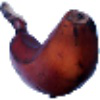

In [61]:
display_img(df_train, img_cat='banana_red')

shape of bytes_img: (6269,)
PIL object:  <PIL.Image.Image image mode=RGB size=100x100 at 0x14B90681F10>


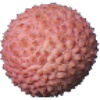

In [62]:
display_img(df_train, img_cat='lychee', img_filename='127_100.jpg')

##### Pré-processing des données (Transfer Learning -> features extraction) à partir d'un modèle InceptionV3 ("Featurisation")
On utilisera pas le fine-tuning ici car ce n'est pas ce qui est demandé.<br />
Bien que pour l'optimisation du modèle ensuite c'est l'option que l'on pourrait ensivager pour maximiser les résultats suivant le classifier mis en oeuvre.

###### Import du modèle InceptionV3 pour la featurisation, on enlève la dernière couche.
- Les "workers" de Spark doivent pouvoir récupérer les poids (weights) du modèle. C'est bien du transfer learning par principe.
- A voir en déploiement: InceptionV3 est un modèle compacte (qq MBytes). Idée: Transférer au driver Spark qui envoie les poids aux workers. (sinon c'est distribué directement (disque))

In [3]:
# For Inception-v3, the input needs to be 299×299 RGB images, and the output is a 2048 dimensional vector.
# Modèle qui accepte les entrées inférieures à 299x299 mais pas en-dessous de 75x75 par contre (pas de 64*64 donc)
model_inception_v3 = InceptionV3(include_top=False)
model_inception_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [64]:
# https://sparkbyexamples.com/spark/spark-broadcast-variables/
model_weights_saved = spark_conn.broadcast(model_inception_v3.get_weights())

def model_for_feats():
    """
    Fonction qui permet de charger le modèle InceptionV3 avec les poids et enlève la dernière couche.
    """
    model = InceptionV3(include_top=False, weights=None)
    model.set_weights(model_weights_saved.value)
    
    return model

###### Fonctions de chargement et de transformation des images ->  utilisation d'un Pandas UDF

In [65]:
def preprocess_img(bytes_img):
    """
    Fonction qui permet de récupérer l'image du spark dataframe en bytes pour l'utiliser ensuite
    pour la prédiction au bon format via le modèle choisi (InceptionV3) pour la featurisation de celle-ci.
    """
    
    # On lit l'image et on resize
    img = Image.open(io.BytesIO(bytes_img)).resize([100, 100])
    # on transformer en array (merci keras)
    img_arr = img_to_array(img)
    # on préprocesse pour le traitement par batch dans le modèle (fonction keras)
    # https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input
    img_prep = preprocess_input(img_arr)
    
    return img_prep

In [13]:
def ps_featurization(model, set_of_series):
    """
    Fonction qui permet de traiter une pandas séries d'images (Bytes) et de les récupérer transformées (featurized) par le modèle. (=extraction de features).
    
    Args:
        set_of_series (pandas.Series): Pandas Series d'images transformées par preprocess_img (opération de "mapping").
    
    Returns:
        pd.Series: Pandas Series d'images "transformées" par le modèle.
    
    """
    
    # pour chaque image de la pandas series on préprocesse l'image sur format classique Bytes to array
    input_ps = np.stack(set_of_series.map(preprocess_img))
    # on récupère la série d'image transformée par le modèle
    preds_ps = model.predict(input_ps)
    # on "flatten" nos images et on retransforme en pandas Series
    output_list = [pred_ps.flatten() for pred_ps in preds_ps]
    output_ps = pd.Series(output_list)  # dtype=np.float64
    
    return output_ps

Notes perso conservées pour montrer la démarche (pandas UDF):
- https://spark.apache.org/docs/latest/api/python/_modules/pyspark/sql/pandas/functions.html
- ici c'est bien un panda_udf -> "générateur"

- old type hint: @pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)

- https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.functions.pandas_udf.html
- Important: The length of each series is the length of a batch internally used.

- https://issues.apache.org/jira/browse/SPARK-28264
- def pandas_udf_gen(set_of_series_batch: Iterator[Tuple[pd.Series, pd.Series]]) -> Iterator[pd.Series]:  # Intéressant -> A conserver

In [66]:
@pandas_udf('array<float>')
def pandas_udf_gen(set_of_series_batch: Iterator[pd.Series]) -> Iterator[pd.Series]:

    """
    Fonction qui est un générateur (Iterator en anglais) et qui permet de traiter,
    par lot les Pandas Series d'images pour les transformer (featuriser).
    
    Note: le décorateur est essentiel pour déclarer un objet de type pandas_udf.
    
    Args:
        set_of_series_batch (pandas.Series): correspond à un batch de données,
        qui est un des pandas.Series d'images passées en argument.
        
    Yields:
        Les pandas.Series transformées par le modèle.
    """

    model = model_for_feats()
    
    for set_of_series in set_of_series_batch:
        yield ps_featurization(model, set_of_series)

###### Excécution de la transformation (réduction de dimensions) par le modèle (Featurisation)
Remarque:
https://spark.apache.org/docs/3.0.0/sql-pyspark-pandas-with-arrow.html#setting-arrow-batch-size<br />
Pour effectuer cette opération sur ce dataset assez large (ici le train set fait autour de 67 000 entrées),<br />
il est nécessaire de définir la taille du nombre de batchs passés à chaque "iteration", <br />
sinon l'opération de traitement via le panda_udf risque de faire planter mon ordinateur (confirmer par essais sans paramétrage).<br />

In [15]:
spark_sess.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")  # 512, 1024 -> des puissances de 2 c'est bien.

In [ ]:
%%script echo skipping
%%time
# https://sparkbyexamples.com/spark/spark-repartition-vs-coalesce/
# function repartition() that allows controlling the data distribution on the Spark cluster
# pourrait permettre d'augmenter le nombre de partitions par contre c'est co¨ûteux en ressources...
# df_train = df_train.repartition(32).select("path", pandas_udf_gen("content").alias("features"), "label")  # lazy (=transformation)
df_train = df_train.select("path", pandas_udf_gen("content").alias("features"), "label")  # lazy (=transformation(s))

In [21]:
%%script echo skipping
%%time
df_train.show()

+--------------------+--------------------+------+--------------------+--------------+
|                path|    modificationTime|length|             content|         label|
+--------------------+--------------------+------+--------------------+--------------+
|file:/G:/p8_jc_im...|2021-11-17 17:18:...|  7437|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|2021-11-17 17:18:...|  7434|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|2021-11-17 17:16:...|  7424|[FF D8 FF E0 00 1...|pineapple_mini|
|file:/G:/p8_jc_im...|2021-11-17 17:18:...|  7423|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|2021-11-17 17:18:...|  7416|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|2021-11-17 17:18:...|  7415|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|2021-11-17 17:16:...|  7410|[FF D8 FF E0 00 1...|pineapple_mini|
|file:/G:/p8_jc_im...|2021-11-17 17:18:...|  7407|[FF D8 FF E0 00 1...|     raspberry|
|file:/G:/p8_jc_im...|2021-11-17 17:18:...|

In [16]:
%%script echo skipping
# Vérification de la taille des vecteurs en sortie du modèle
feature = df_train.select('features').take(1)[0][0]
# print(feature[:5])
feature_len = len(feature)
print("Taille de sortie du vecteur (InceptionV3): {}".format(feature_len))

Taille de sortie du vecteur (InceptionV3): 2048


In [18]:
%%script echo skipping
%%time
# https://spark.apache.org/docs/latest/sql-data-sources-parquet.html
# https://sparkbyexamples.com/spark/spark-read-write-dataframe-parquet-example/
# Enregistrement au format parquet
# Rappel: Total executor memory = total RAM per instance / number of executors per instance
# df_train.coalesce(1).write.mode("overwrite").parquet(path + '/parquet/df_train_featurized')
df_train.write.mode("overwrite").parquet(path + '/parquet/df_train')

Couldn't find program: 'echo'


##### Pipeline Stages with Pyspark
Le point d'entrée est: df_train

In [67]:
# Création d'un transformer "custom" pour la pipeline.
import pyspark.sql.functions as F

from pyspark import keyword_only
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql import DataFrame
from pyspark.sql.types import StringType

class CustomTransformer(Transformer, HasInputCol, HasOutputCol, DefaultParamsReadable, DefaultParamsWritable):
    
    input_col = Param(Params._dummy(), "input_col", "input column name.", typeConverter=TypeConverters.toString)
    output_col = Param(Params._dummy(), "output_col", "output column name.", typeConverter=TypeConverters.toString)
    
    @keyword_only
    def __init__(self, input_col: str = "input", output_col: str = "output"):
        
        super(CustomTransformer, self).__init__()
        self._setDefault(input_col=None, output_col=None)
        kwargs = self._input_kwargs
        self.set_params(**kwargs)
    
    @keyword_only
    def set_params(self, input_col: str = "input", output_col: str = "output"):
        
        kwargs = self._input_kwargs
        self._set(**kwargs)
    
    def get_input_col(self):
        
        return self.getOrDefault(self.input_col)
    
    def get_output_col(self):
        
        return self.getOrDefault(self.output_col)
    
    def _transform(self, df: DataFrame):
        
        input_col = self.get_input_col()
        output_col = self.get_output_col()
        
        # to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
        # return df.withColumn(output_col, to_vector(pandas_udf_gen(input_col)))
        return df.withColumn(output_col, pandas_udf_gen(input_col))

###### Pipeline 1

In [68]:
indexer = StringIndexer(inputCol='label', outputCol='label_idx')
featurizer = CustomTransformer(input_col='content', output_col='features')  # df_train, df_test

In [20]:
from pyspark.ml import Pipeline

pipeline_1 = Pipeline(stages=[indexer, featurizer])
pipeline_1_model = pipeline_1.fit(df_train)
df_train_idx_feats = pipeline_1_model.transform(df_train)
df_test_idx_feats = pipeline_1_model.transform(df_test)

df_train_idx_feats = df_train_idx_feats.select("path", "features", "label", "label_idx")
df_test_idx_feats = df_test_idx_feats.select("path", "features", "label", "label_idx")
print(df_train_idx_feats.show())
print(df_test_idx_feats.show())

+--------------------+--------------------+--------------+---------+
|                path|            features|         label|label_idx|
+--------------------+--------------------+--------------+---------+
|file:/G:/p8_jc_im...|[0.23239073, 0.0,...|     raspberry|     86.0|
|file:/G:/p8_jc_im...|[0.0, 0.0, 0.4001...|     raspberry|     86.0|
|file:/G:/p8_jc_im...|[0.0, 1.1064178, ...|pineapple_mini|     24.0|
|file:/G:/p8_jc_im...|[0.01444225, 0.0,...|     raspberry|     86.0|
|file:/G:/p8_jc_im...|[1.0919065, 0.0, ...|     raspberry|     86.0|
|file:/G:/p8_jc_im...|[0.6957115, 0.0, ...|     raspberry|     86.0|
|file:/G:/p8_jc_im...|[0.0, 2.9302442, ...|pineapple_mini|     24.0|
|file:/G:/p8_jc_im...|[0.59812486, 0.0,...|     raspberry|     86.0|
|file:/G:/p8_jc_im...|[1.128924, 0.0, 1...|     raspberry|     86.0|
|file:/G:/p8_jc_im...|[0.0, 0.0, 0.7891...|     raspberry|     86.0|
|file:/G:/p8_jc_im...|[0.98141885, 0.0,...|     raspberry|     86.0|
|file:/G:/p8_jc_im...|[1.607154, 0

In [21]:
%%time
df_train_idx_feats.write.mode("overwrite").parquet(path + '/parquet/df_train_idx_feats')
df_test_idx_feats.write.mode("overwrite").parquet(path + '/parquet/df_test_idx_feats')

Wall time: 2h 5min 8s


In [13]:
%%time
df_train_idx_feats = spark_sess.read.parquet(path + '/parquet/df_train_idx_feats')  # spark_sess
df_test_idx_feats = spark_sess.read.parquet(path + '/parquet/df_test_idx_feats')

Wall time: 3.81 s


###### Conversion pyspark dtype: "array\<float\>" à "vector"

In [14]:
# Conversion en vecteurs UDT
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

to_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
# ATTTENTION REPARTITION RDD nécessaire -> 64 pas moins -> ça marche
df_train_idx_feats = df_train_idx_feats.repartition(64).select("path", "label", "label_idx", "features", to_vector("features").alias("features_vect"))
df_test_idx_feats = df_test_idx_feats.repartition(64).select("path", "label", "label_idx", "features", to_vector("features").alias("features_vect"))

# Contrôle Le dtype de la colonne 'features' en sortie -> array<float> -> vector
print(dict(df_train_idx_feats.dtypes)['features_vect'])
print(dict(df_test_idx_feats.dtypes)['features_vect'])

vector
vector


In [15]:
print(df_train_idx_feats.show(5))
print(df_test_idx_feats.show(5))

+--------------------+----------------+---------+--------------------+--------------------+
|                path|           label|label_idx|            features|       features_vect|
+--------------------+----------------+---------+--------------------+--------------------+
|file:/G:/p8_jc_im...| apple_pink_lady|    106.0|[2.99704, 0.0, 0....|[2.99704003334045...|
|file:/G:/p8_jc_im...|strawberry_wedge|      6.0|[0.90275586, 0.31...|[0.90275585651397...|
|file:/G:/p8_jc_im...|  apple_golden_1|     91.0|[0.24424633, 0.17...|[0.24424633383750...|
|file:/G:/p8_jc_im...|      pepper_red|     20.0|[0.0, 0.0, 0.0, 5...|[0.0,0.0,0.0,5.21...|
|file:/G:/p8_jc_im...|      watermelon|     95.0|[0.68813837, 0.0,...|[0.68813836574554...|
+--------------------+----------------+---------+--------------------+--------------------+
only showing top 5 rows

None
+--------------------+------------------+---------+--------------------+--------------------+
|                path|             label|label_i

###### Pipeline 2

In [16]:
# Centrage des données avant PCA
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol='features_vect', outputCol='features_std', withMean=True, withStd=False)

In [20]:
# PCA sur les variables extraites du modèle (rappel vecteur de taille 2048)
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.PCA.html
from pyspark.ml.feature import PCA
pca = PCA(k=1000, inputCol='features_std', outputCol='features_pca')  # inputCol=scaler.getOutputCol()

In [22]:
%%script echo skipping
%%time
# Pipeline_2 réutilisable pour le jeu de test
pipeline_2 = Pipeline(stages=[scaler, pca])
pipeline_2_model = pipeline_2.fit(df_train_idx_feats)
df_train_idx_feats_std_pca = pipeline_2_model.transform(df_train_idx_feats)

Couldn't find program: 'echo'


In [18]:
%%time
scaler_model = scaler.fit(df_train_idx_feats)
df_train_idx_feats_std = scaler_model.transform(df_train_idx_feats)
df_test_idx_feats_std = scaler_model.transform(df_test_idx_feats)

Wall time: 50.7 s


In [19]:
%%time
# données centrées -> on enregistre
# Merci Windows : java.lang.UnsatisfiedLinkError: org.apache.hadoop.io.nativeio.NativeIO$Windows.access
# besoin de modifier l'installation de hadoop pour windows pour que cela fonctionne (winutils + hadoop.dll...)
# ressources: https://github.com/cdarlint/winutils
df_train_idx_feats_std.write.mode("overwrite").parquet(path + '/parquet/df_train_idx_feats_std')
df_test_idx_feats_std.write.mode("overwrite").parquet(path + '/parquet/df_test_idx_feats_std')

Wall time: 1min 37s


In [17]:
%%time
df_train_idx_feats_std = spark_sess.read.parquet(path + '/parquet/df_train_idx_feats_std')
df_test_idx_feats_std = spark_sess.read.parquet(path + '/parquet/df_test_idx_feats_std')

Wall time: 446 ms


In [18]:
print(df_train_idx_feats_std.show(5))
print(df_test_idx_feats_std.show(5))

+--------------------+--------------+---------+--------------------+--------------------+--------------------+
|                path|         label|label_idx|            features|       features_vect|        features_std|
+--------------------+--------------+---------+--------------------+--------------------+--------------------+
|file:/G:/p8_jc_im...|apple_golden_1|     91.0|[0.0, 0.9719454, ...|[0.0,0.9719454050...|[-1.2890359928933...|
|file:/G:/p8_jc_im...|pomelo_sweetie|    113.0|[0.0, 1.7011687, ...|[0.0,1.7011686563...|[-1.2890359928933...|
|file:/G:/p8_jc_im...|       tangelo|     89.0|[2.4255252, 0.0, ...|[2.42552518844604...|[1.13648919555269...|
|file:/G:/p8_jc_im...|        papaya|     44.0|[1.0729231, 0.288...|[1.07292306423187...|[-0.2161129286614...|
|file:/G:/p8_jc_im...|pineapple_mini|     24.0|[0.0, 1.5882581, ...|[0.0,1.5882581472...|[-1.2890359928933...|
+--------------------+--------------+---------+--------------------+--------------------+--------------------+
o

In [21]:
%%time
pca_model = pca.fit(df_train_idx_feats_std)
df_train_idx_feats_std_pca = pca_model.transform(df_train_idx_feats_std)
df_test_idx_feats_std_pca = pca_model.transform(df_test_idx_feats_std)

Wall time: 2min 17s


In [13]:
%%script echo skipping
# Taux de variance expliqué total par les 1000 composantes
print("Taux de variance total expliqué: {} %".format(np.round(np.sum(100 * pca_model.explainedVariance.toArray()), 2)))

Taux de variance total expliqué: 99.26 %


In [67]:
# print(df_train_idx_std_pca.show(5))

In [24]:
print(df_train_idx_feats_std_pca.show(5))
print(df_test_idx_feats_std_pca.show(5))

+--------------------+--------------+---------+--------------------+--------------------+--------------------+--------------------+
|                path|         label|label_idx|            features|       features_vect|        features_std|        features_pca|
+--------------------+--------------+---------+--------------------+--------------------+--------------------+--------------------+
|file:/G:/p8_jc_im...|apple_golden_1|     91.0|[0.0, 0.9719454, ...|[0.0,0.9719454050...|[-1.2890359928933...|[-13.705962589684...|
|file:/G:/p8_jc_im...|pomelo_sweetie|    113.0|[0.0, 1.7011687, ...|[0.0,1.7011686563...|[-1.2890359928933...|[1.54286876560954...|
|file:/G:/p8_jc_im...|       tangelo|     89.0|[2.4255252, 0.0, ...|[2.42552518844604...|[1.13648919555269...|[-9.8002919304511...|
|file:/G:/p8_jc_im...|        papaya|     44.0|[1.0729231, 0.288...|[1.07292306423187...|[-0.2161129286614...|[2.89101594982602...|
|file:/G:/p8_jc_im...|pineapple_mini|     24.0|[0.0, 1.5882581, ...|[0.0,1.5

In [25]:
# vérification d'usage
print(dict(df_train_idx_feats_std_pca.dtypes)['features_pca'])
print(dict(df_test_idx_feats_std_pca.dtypes)['features_pca'])

vector
vector


In [26]:
df_train_idx_feats_std_pca = df_train_idx_feats_std_pca.select("path", "features_pca", "label", "label_idx")
df_train_idx_feats_std_pca = df_train_idx_feats_std_pca\
    .withColumnRenamed("label", "label_string") \
    .withColumnRenamed("label_idx", "label") \
    .withColumnRenamed("features_pca", "features")
print(df_train_idx_feats_std_pca.printSchema())

df_test_idx_feats_std_pca = df_test_idx_feats_std_pca.select("path", "features_pca", "label", "label_idx")
df_test_idx_feats_std_pca = df_test_idx_feats_std_pca\
    .withColumnRenamed("label", "label_string") \
    .withColumnRenamed("label_idx", "label") \
    .withColumnRenamed("features_pca", "features")
print(df_test_idx_feats_std_pca.printSchema())

root
 |-- path: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label_string: string (nullable = true)
 |-- label: double (nullable = true)

None
root
 |-- path: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- label_string: string (nullable = true)
 |-- label: double (nullable = true)

None


In [28]:
%%script echo skipping
%%time
df_train_idx_feats_std_pca.write.mode("overwrite").parquet(path + '/parquet/df_train_idx_feats_std_pca')
df_test_idx_feats_std_pca.write.mode("overwrite").parquet(path + '/parquet/df_test_idx_feats_std_pca')

Wall time: 1min 6s


In [24]:
%%time
df_train_idx_feats_std_pca = spark_sess.read.parquet(path + '/parquet/df_train_idx_feats_std_pca')
df_test_idx_feats_std_pca = spark_sess.read.parquet(path + '/parquet/df_test_idx_feats_std_pca')

Wall time: 140 ms


In [25]:
print(df_train_idx_feats_std_pca.show(35))
print(df_test_idx_feats_std_pca.show(35))

+--------------------+--------------------+------------------+-----+
|                path|            features|      label_string|label|
+--------------------+--------------------+------------------+-----+
|file:/G:/p8_jc_im...|[5.37120918526439...|melon_piel_de_sapo|  4.0|
|file:/G:/p8_jc_im...|[-7.9193757089372...|        granadilla| 64.0|
|file:/G:/p8_jc_im...|[-2.4017533155304...|      tomato_heart| 16.0|
|file:/G:/p8_jc_im...|[-1.9302504037973...|          tomato_3|  8.0|
|file:/G:/p8_jc_im...|[5.01945281185360...|          tomato_1|  7.0|
|file:/G:/p8_jc_im...|[0.87380556308374...|        watermelon| 95.0|
|file:/G:/p8_jc_im...|[3.62373510850024...|           tangelo| 89.0|
|file:/G:/p8_jc_im...|[10.2467576860328...|           tangelo| 89.0|
|file:/G:/p8_jc_im...|[-21.379577348020...|apple_red_yellow_2| 17.0|
|file:/G:/p8_jc_im...|[2.10027114472608...|              kiwi|101.0|
|file:/G:/p8_jc_im...|[-14.686716112571...|      pear_forelle| 13.0|
|file:/G:/p8_jc_im...|[1.123368749

##### CrossValidation avec RandomForestClassifier

In [33]:
%%time
# On définit notre Estimateur (RFC pour comparaison avec notre baseline SGDClassifier à 70% et RFC à 83% d'accuracy)
# https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.classification.RandomForestClassifier.html
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

rfc = RandomForestClassifier(labelCol='label', featuresCol='features', seed=42)  # labelCol='label_idx', featuresCol='features_pca'
# pipeline = Pipeline(stages=[indexer, featurizer, scaler, pca, rfc])
# pipeline_2 = Pipeline(stages=[scaler, pca, rfc])

rfc_params = ParamGridBuilder() \
            .addGrid(rfc.featureSubsetStrategy, ['all', 'sqrt', 'log2']) \  # 'onethird' (sqrt)
            .addGrid(rfc.maxDepth, [5, 10, 15]) \  # (10)
            # .addGrid(rfc.numTrees, [350, 400]) ?  # l'ordinateur plante...
            .build()

evaluator = MulticlassClassificationEvaluator(metricName='accuracy')  # il vaudrait mieux prendre weightPrecision, weightRecall

# test initial avec 60 modèles (ici:4x3 x5 folds) -> on devra certainement alléger (ordinateur peu puissant/coût serveur) -> confirmé... RAM
rfc_cv = CrossValidator(
    estimator=rfc, # pipeline,  # rfc, on pourrait passer la pipeline complète en ajoutant le modèle avec assez de puissance.
    evaluator=evaluator,
    estimatorParamMaps=rfc_params,
    seed=42,
    numFolds=5 # 3 -> pas de changements
)

Wall time: 60.8 ms


In [ ]:
%%time
rfc_model = rfc_cv.fit(df_train_idx_feats_std_pca)

In [ ]:
print(rfc_model.bestModel)

In [36]:
# enregistrement du meilleur modèle
# https://spark.apache.org/docs/2.3.0/api/python/pyspark.ml.html#pyspark.ml.classification.LogisticRegression.save
rfc_model.bestModel.save('rfc_model')
# rfc_model.bestModel.save('rfc_model_2')

In [19]:
# https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html?highlight=crossvalidator
# print(rfc_model.avgMetrics)

In [8]:
# chargement du modèle
from pyspark.ml.classification import RandomForestClassificationModel
rfc_model = RandomForestClassificationModel.load('rfc_model')

In [70]:
# Quels sont les hyperparamètres qui ont été choisis ?
print(rfc_model.explainParam('maxDepth'), "\n")
print(rfc_model.explainParam('featureSubsetStrategy'), "\n")
# rfc_model.getEstimatorParamMaps()[ np.argmax(rfc_model.avgMetrics) ]  # issu de la cross-validation directement

maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30]. (default: 5, current: 10) 

featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto' (default: auto, current: sqrt) 



##### Evaluation sur les données de test préparées

In [29]:
%%time
predictions = rfc_model.transform(df_test_idx_feats_std_pca)

Wall time: 70.8 ms


In [30]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(
    metricName='accuracy',
    # labelCol="label",
    # predictionCol="prediction"
)

In [31]:
# On évalue le modèle sur le le jeu de test -> accuracy ici
print("Accuracy: {:.2f} %".format(100*evaluator.evaluate(rfc_model.transform(df_test_idx_feats_std_pca))))

Accuracy: 64.64 %


Note: l'évaluation de l'accuracy sur le jeu de test est "mauvaise" ici.<br />
C'est plutôt attendu car la grille d'hyperparamètres du gridsearch n'est pas du tout adaptée.<br />
Laissé pour exemple. Il faudrait un PC bien plus puissant (local) ou un serveur pour le faire avec une grille étendue.<br />
Remarque: l'exécution de Pyspark en local (sur un PC) n'est pas adaptée. Le "fit" prend énormément de temps (ici 14h en moyenne pour les qq éssais réalisés).

In [32]:
weighted_precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
print("weighted_precision: {:.2f} %".format(weighted_precision*100))

weighted_recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
print("weighted_recall:   {:.2f} %".format(weighted_recall*100))

weighted_precision: 64.10 %
weighted_recall:   64.64 %


In [33]:
predictions.select("label_string", "label", "prediction").show(25)

+------------------+-----+----------+
|      label_string|label|prediction|
+------------------+-----+----------+
|    nectarine_flat| 92.0|      10.0|
|       lemon_meyer| 72.0|      67.0|
|            pear_2| 15.0|      15.0|
|    pineapple_mini| 24.0|      24.0|
|       apple_red_3|122.0|     119.0|
|    pineapple_mini| 24.0|      24.0|
|             peach| 45.0|      80.0|
|  grapefruit_white| 40.0|      40.0|
|           tangelo| 89.0|      89.0|
|      pear_forelle| 13.0|      13.0|
|  grapefruit_white| 40.0|      40.0|
|        pear_stone| 10.0|       1.0|
|               fig| 12.0|      12.0|
|     tomato_maroon|127.0|     127.0|
|       cauliflower| 11.0|      11.0|
|       onion_white|121.0|      46.0|
|            walnut|  9.0|       9.0|
|       apple_red_3|122.0|     122.0|
|              kiwi|101.0|      15.0|
|          tomato_3|  8.0|       8.0|
|apple_crimson_snow|119.0|     105.0|
|      potato_sweet|115.0|      98.0|
|      pear_monster| 80.0|      80.0|
|apple_red_y

#### Conversion du notebook en ligne en script python pour le driver via un spark-submit
Note: ici refait en local en téléchargeant le notebook du cluster pour mémoire sur ce projet.

In [5]:
import nbformat
from nbconvert import PythonExporter

notebook_name = '/aws/p8-jc-notebook-aws.ipynb'
script_name = '/aws/p8-jc-fruits-aws.py'

with open(path + notebook_name) as notebook:
    nb = nbformat.reads(notebook.read(), nbformat.NO_CONVERT)

exporter = PythonExporter()

# tuple avec des metadoonées
source, meta = exporter.from_notebook_node(nb)

with open(path + script_name, 'w+') as python_script:
    python_script.write(source)

#### Conversion des données préparées avec le cluster (AWS EMR)
But: essayer de compresser au mieux avec le format csv pour l'inclure dans l'upload de soutance OC limité à 200Mo au total.<br />
Fichiers récupérés: Résultats des données train/test transformées (df_train_ready et df_test_ready) provenant du bucket s3 associé au cluster aws emr. (format parquet)<br />
Download en utilisant simplement AWS CLI: aws s3 cp s3://p8-jc-fruits/data G:\backup_bucket_s3 --recursive<br />
Rappel: Suppose d'avoir configuré les droits et accès préalablement (aws configure) + console management bucket s3 pour l'utilisateur.

In [7]:
df_train_ready_location = r'G:\backup_bucket_s3\df_train_ready'
df_test_ready_location = r'G:\backup_bucket_s3\df_test_ready'

In [8]:
%%time
df_train_ready = pd.read_parquet(df_train_ready_location)
df_test_ready = pd.read_parquet(df_test_ready_location)

Wall time: 3.99 s


In [9]:
print(df_train_ready.shape)
print(df_test_ready.shape)

(67692, 5)
(22688, 5)


In [10]:
# vérification de taille des vecteurs de sorties transformés par InceptionV3
print(len(df_train_ready.loc[0, 'features']))

2048


In [11]:
# drop de colonne -> pas utile pour l'affichage pandas ici
df_train_ready.drop('features_vect', axis=1, inplace=True)
df_test_ready.drop('features_vect', axis=1, inplace=True)

In [12]:
df_train_ready.head()

,path,label,label_idx,features
0,s3a://p8-jc-fruits/images/train/raspberry/176_...,raspberry,86.0,"[0.23238954, 0.0, 1.034526, 1.0302173, 0.0, 0...."
1,s3a://p8-jc-fruits/images/train/raspberry/179_...,raspberry,86.0,"[0.0, 0.0, 0.40017095, 1.3441322, 0.0, 0.0, 2...."
2,s3a://p8-jc-fruits/images/train/pineapple_mini...,pineapple_mini,24.0,"[0.0, 1.1064162, 4.4996066, 0.0, 0.0, 2.114598..."
3,s3a://p8-jc-fruits/images/train/raspberry/157_...,raspberry,86.0,"[0.014440462, 0.0, 0.4930686, 1.6176742, 0.0, ..."
4,s3a://p8-jc-fruits/images/train/raspberry/131_...,raspberry,86.0,"[1.0919069, 0.0, 1.7694776, 0.64952576, 0.1221..."


In [13]:
%%time
# conversion pandas to csv
df_train_ready_output = r'G:\backup_bucket_s3\df_train_ready.csv.gz'
df_test_ready_output = r'G:\backup_bucket_s3\df_test_ready.csv.gz'

df_train_ready.to_csv(df_train_ready_output, index=False, compression='gzip')
df_test_ready.to_csv(df_test_ready_output, index=False, compression='gzip')

Wall time: 9.85 s


In [14]:
# vérifications
df_train_ready_csv = pd.read_csv(df_train_ready_output, compression='gzip', header=0, sep=',')
print("df_train_ready_csv shape: {}".format(df_train_ready_csv.shape))
display(df_train_ready_csv.head())

df_test_ready_csv = pd.read_csv(df_test_ready_output, compression='gzip', header=0, sep=',')
print("df_test_ready_csv shape: {}".format(df_test_ready_csv.shape))
display(df_test_ready_csv.head())

df_train_ready_csv shape: (67692, 4)


,path,label,label_idx,features
0,s3a://p8-jc-fruits/images/train/raspberry/176_...,raspberry,86.0,[0.23238954 0. 1.034526 ... 0.286408...
1,s3a://p8-jc-fruits/images/train/raspberry/179_...,raspberry,86.0,[0. 0. 0.40017095 ... 0.338417...
2,s3a://p8-jc-fruits/images/train/pineapple_mini...,pineapple_mini,24.0,[0. 1.1064162 4.4996066 ... 1.299859...
3,s3a://p8-jc-fruits/images/train/raspberry/157_...,raspberry,86.0,[0.01444046 0. 0.4930686 ... 0.763897...
4,s3a://p8-jc-fruits/images/train/raspberry/131_...,raspberry,86.0,[1.0919069 0. 1.7694776 ... 0.687976...


df_test_ready_csv shape: (22688, 4)


,path,label,label_idx,features
0,s3a://p8-jc-fruits/images/test/watermelon/r_10...,watermelon,95.0,[1.2493644 0. 0. ... 2.715819 2...
1,s3a://p8-jc-fruits/images/test/watermelon/r_10...,watermelon,95.0,[0.8011472 0. 0. ... 2.8643663 3...
2,s3a://p8-jc-fruits/images/test/watermelon/r_10...,watermelon,95.0,[0.99742985 0. 0. ... 1.032366...
3,s3a://p8-jc-fruits/images/test/watermelon/r_10...,watermelon,95.0,[1.1327485 0. 0. ... 1.9415758 2...
4,s3a://p8-jc-fruits/images/test/watermelon/r_95...,watermelon,95.0,[0.81870806 0. 0. ... 2.777600...


In [16]:
# # !pip install hurry.filesize
from hurry.filesize import size, si

df_train_ready_size = size(os.path.getsize(df_train_ready_output), system=si)  # (getsize) taille en bytes -> conversion 'si' pour 1k = 1000
df_test_ready_size = size(os.path.getsize(df_test_ready_output), system=si)
print("Taille de df_train_ready.csv.gz: {}".format(df_train_ready_size))
print("Taille de df_test_ready.csv.gz: {}".format(df_test_ready_size))

Taille de df_train_ready.csv.gz: 1M
Taille de df_test_ready.csv.gz: 632K
